In [1]:
import torch
from torch import tensor

# Questionaire

1) Implement a single neuron

In [2]:
x = torch.randn(3)
w = torch.randn(3)
b = 1

In [3]:
def neuron(x, w, b):
    return sum(wi * xi for wi, xi in zip(w, x)).item() + b

In [4]:
print(x)
print(w)
neuron(x, w, b)

tensor([-1.9662, -0.2524,  0.0082])
tensor([-0.1280,  0.8786,  0.6314])


1.0350211560726166

2) Implement ReLU

In [5]:
def relu(x):
    return x if x >= 0 else 0

3) Write the Python code for a dense layer in terms of matrix multiplication.

In [6]:
x = torch.randn(2, 3)
w = torch.randn(2, 3)
b = tensor((1, 2))

In [7]:
def dense_layer(x, w, b):
    return x @ w.t() + b

In [8]:
print(x)
print(w)
print(b)
print()
dense_layer(x, w, b)

tensor([[-0.5692, -0.4413,  0.1623],
        [-0.6647,  0.0241, -1.1251]])
tensor([[-0.9437, -0.3869,  0.2552],
        [-0.7195,  1.5699, -0.5990]])
tensor([1, 2])



tensor([[1.7493, 1.6196],
        [1.3307, 3.1901]])

4) Write the Python code for a dense layer in plain Python (that is, with list comprehensions and functionality built into Python).

In [9]:
def dense_layer(x, w, b):
    out = []
    for batch in x:
        b_out = []
        for neur, bi in zip(w, b):
            b_out.append(sum(xi * wi for xi, wi in zip(batch, neur)) + bi)

        out.append(b_out)

    return out

dense_layer(x, w, b)

[[tensor(1.7493), tensor(1.6196)], [tensor(1.3307), tensor(3.1901)]]

11) Write the PyTorch code to test whether every element of a is greater than the corresponding element of b.

In [10]:
a = torch.rand(3)
b = torch.rand(3)
print(f'{a}\n{b}')
(a > b).all()

tensor([0.9407, 0.3795, 0.7352])
tensor([0.0934, 0.4565, 0.1057])


tensor(False)

23) Implement matmul using Einstein summation.

In [11]:
def matmul(a, b):
    return torch.einsum('ij,jk->ik', a, b)

In [12]:
a = tensor([[1, 2], [3, 4]])
b = tensor([[2], [1]])
matmul(a, b)

tensor([[ 4],
        [10]])

39) Write nn.Linear from scratch.

In [13]:
import torch.nn as nn
from math import sqrt

In [14]:
class LinearLayer(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = nn.Parameter(torch.randn(n_out, n_in) * sqrt(1/n_in))
        self.b = nn.Parameter(torch.zeros(n_out))

    def forward(self, x):
        return x @ self.w.t() + self.b

# Further research

# 1) Implement ReLU as a torch.autograd.Function and train a model with it.

I will train a model with it in point 2

In [15]:
class MyReLUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        out = x.clamp_min(0)
        ctx.save_for_backward(out)
        return out

    @staticmethod
    def backward(ctx, grad_out):
        out, = ctx.saved_tensors
        return grad_out * (out > 0).float()

In [16]:
class MyReLU(nn.Module):
    def forward(self, x):
        return MyReLUFunction.apply(x)

# 2) Learn about the unfold method in PyTorch, and use it along with matrix multiplication to implement your own 2D convolution function. Then train a CNN that uses it.

In [17]:
import torch.nn.functional as F

In [18]:
# logic behind convolution - demonstration
input = torch.rand(2, 3, 3, 3)
bias = tensor((10000, 5000, 2000))

# Define padding: (pad_left, pad_right, pad_top, pad_bottom)
padding = [1]*4  # Adding 1 pixel of padding on all sides

# Apply padding to the input tensor
padded = F.pad(input, padding)
print(f"Padded tensor shape: {padded.shape}")

# unfold on 2 last dimensions as we will slide on them, set stride to 1 and kernel size to 2
unfolded_input = padded.unfold(2, 2, 1).unfold(3, 2, 1)
# unsqueeze after 2nd coordinate, to get the shape: batch_size x empty x in_channels x new_height x new_width x kernel_size x kernel_size
unfolded_input = unfolded_input.unsqueeze(1)
print(f"Final shape of the input: {unfolded_input.shape}")

# initialise kernel with shape: out_channels x in_channels x kernel_size x kernel_size
kernel = torch.rand(3, 3, 2, 2)
# change the shape to: empty x out_channels x in_channels x empty x empty x kernel_size x kernel_size
kernel = kernel.unsqueeze(-3).unsqueeze(-3).unsqueeze(0)
print(f"Final shape of the kernel: {kernel.shape}")

# apply convolution, sum over in_channels x kernel_size x kernel_size
b = (unfolded_input * kernel).sum(dim=(2, -2, -1)) + bias[None, :, None, None]
print(b.shape)

Padded tensor shape: torch.Size([2, 3, 5, 5])
Final shape of the input: torch.Size([2, 1, 3, 4, 4, 2, 2])
Final shape of the kernel: torch.Size([1, 3, 3, 1, 1, 2, 2])
torch.Size([2, 3, 4, 4])


In [19]:
class MyConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=True, stride=1, padding=0):
        super().__init__()
        self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding = in_channels, out_channels, kernel_size, stride, padding

        # set the shape to: empty x out_channels x in_channels x empty x empty x kernel_size x kernel_size
        self.kernel = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size).unsqueeze(-3).unsqueeze(-3).unsqueeze(0))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        padding = [self.padding] * 4
        padded = F.pad(x, padding)

        # unfold on 2 last dimensions as we will slide on them
        unfolded_input = padded.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        # unsqueeze after 2nd coordinate, to get the shape: batch_size x empty x in_channels x new_height x new_width x kernel_size x kernel_size
        unfolded_input = unfolded_input.unsqueeze(1)

        # apply convolution, sum over in_channels x kernel_size x kernel_size
        out = (unfolded_input * self.kernel).sum(dim=(2, -2, -1))

        if self.bias is not None:
            out += self.bias[None, :, None, None]

        return out


Let's train CNN

In [20]:
from fastai.vision.all import *

In [21]:
path = untar_data(URLs.MNIST)

In [22]:
Path.BASE_PATH = path

In [23]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [24]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls(512)

In [25]:
x, y = dls.one_batch()
x.shape

torch.Size([512, 1, 28, 28])

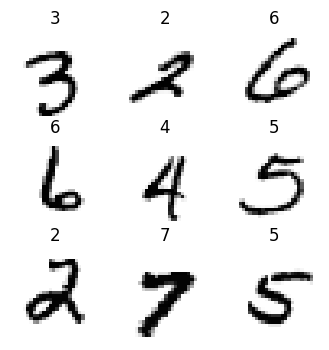

In [26]:
dls.show_batch(max_n=9, figsize=(4,4))

In [36]:
def conv(ni, nf, ks=3, act=True):
    layers = [MyConv(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(MyReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [28]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

In [29]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

My custom ReLU and Convolution

In [37]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.391073,0.095549,0.971000,01:07
1,0.101941,0.069636,0.977500,01:06
2,0.054913,0.041797,0.987200,01:08
3,0.030633,0.030033,0.989900,01:05
4,0.016128,0.027338,0.990400,01:07


In [31]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

Pytorch deafult

In [32]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.178685,0.095457,0.969900,01:06
1,0.077373,0.052988,0.982300,01:03
2,0.048993,0.045788,0.984200,01:03
3,0.030000,0.026380,0.991300,01:05
4,0.015460,0.022986,0.991600,01:03


# 3) Implement everything in this chapter by using NumPy instead of PyTorch.

In [1]:
import torch
from torch import tensor
import numpy as np

## matmul I

In [39]:
def matmul_torch(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [40]:
def matmul_np(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac == br
    c = np.zeros((ar, bc))
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]

    return c

In [41]:
at = tensor([[1, 2, 3], [4, 5, 6]])
bt = tensor([[7, 8], [9, 10], [11, 12]])
an = np.array([[1, 2, 3], [4, 5, 6]])
bn = np.array([[7, 8], [9, 10], [11, 12]])

In [42]:
print(matmul_torch(at,bt))
print()
print(matmul_np(an,bn))

tensor([[ 58.,  64.],
        [139., 154.]])

[[ 58.  64.]
 [139. 154.]]


In [43]:
t1 = torch.randn(5,28*28)
t2 = torch.randn(784,10)
n1 = t1.numpy()
n2 = t2.numpy()

In [44]:
%timeit matmul_torch(t1, t2)

923 ms ± 65.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%timeit matmul_np(n1, n2)

31.1 ms ± 567 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


numpy is ~30x faster than pytorch here

## Elementwise arithmetic

In [9]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
print(a + b)
print(a < b)
print((a < b).all())
print((a != b).all())
print((a + b).mean().item())
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]])
m*m

tensor([12., 14.,  3.])
tensor([False,  True,  True])
tensor(False)
tensor(True)
9.666666984558105


tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

In [10]:
a = np.array([10., 6, -4])
b = np.array([2., 8, 7])
print(a + b)
print(a < b)
print(np.all(a < b))
print(np.all(a != b))
print(np.mean(a + b))
m = np.array([[1., 2, 3], [4,5,6], [7,8,9]])
m*m

[12. 14.  3.]
[False  True  True]
False
True
9.666666666666666


array([[ 1.,  4.,  9.],
       [16., 25., 36.],
       [49., 64., 81.]])

## matmul II

In [11]:
def matmul_torch(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = (a[i] * b[:,j]).sum()
    return c

In [12]:
def matmul_np(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac == br
    c = np.zeros((ar, bc))
    for i in range(ar):
        for j in range(bc): c[i,j] = np.sum((a[i] * b[:,j]))
    return c

In [13]:
print(matmul_torch(at,bt))
print()
print(matmul_np(an,bn))

tensor([[ 58.,  64.],
        [139., 154.]])

[[ 58.  64.]
 [139. 154.]]


In [14]:
%timeit matmul_torch(t1, t2)

3.49 ms ± 577 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit matmul_np(n1, n2)

372 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


numpy is ~4x faster than pytorch here

## Broadcasting

I

In [29]:
a = tensor([10., 6, -4])
print(a > 0)

m = tensor([[1., 2, 3], [4,5,6], [7,8,9]])
print((m - 5) / 2.73)

c = tensor([10.,20,30])
print(m.shape,c.shape)
print(m + c)
print(c + m)

tensor([ True,  True, False])
tensor([[-1.4652, -1.0989, -0.7326],
        [-0.3663,  0.0000,  0.3663],
        [ 0.7326,  1.0989,  1.4652]])
torch.Size([3, 3]) torch.Size([3])
tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])
tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])


In [30]:
an = np.array([10., 6, -4])
print(an > 0)

mn = np.array([[1., 2, 3], [4,5,6], [7,8,9]])
print((m - 5) / 2.73)

cn = np.array([10.,20,30])
print(mn.shape,c.shape)
print(mn + cn)
print(cn + mn)

[ True  True False]
tensor([[-1.4652, -1.0989, -0.7326],
        [-0.3663,  0.0000,  0.3663],
        [ 0.7326,  1.0989,  1.4652]])
(3, 3) torch.Size([3])
[[11. 22. 33.]
 [14. 25. 36.]
 [17. 28. 39.]]
[[11. 22. 33.]
 [14. 25. 36.]
 [17. 28. 39.]]


II

In [31]:
print(c.expand_as(m))

t = c.expand_as(m)
print(t.storage())
print(t.stride(), t.shape)

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])
 10.0
 20.0
 30.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 3]
(0, 1) torch.Size([3, 3])


In [32]:
# no equivalent function to .storage()
tn = np.broadcast_to(cn, mn.shape)
print(tn)
print(tn.strides, tn.shape)

[[10. 20. 30.]
 [10. 20. 30.]
 [10. 20. 30.]]
(0, 8) (3, 3)


8 represents 8 bytes, so it is equivalent to 1 in pytorch, as numpy is using 64 bit floats

III

In [33]:
c = c.unsqueeze(1)
print(m.shape,c.shape)
print(c + m)

torch.Size([3, 3]) torch.Size([3, 1])
tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])


In [34]:
tmp = cn
cn = np.expand_dims(tmp, axis=1)
print(mn.shape, cn.shape)
print(c + m)

(3, 3) (3, 1)
tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])


IV

In [35]:
c.shape, c[None,:].shape,c[:,None].shape

(torch.Size([3, 1]), torch.Size([1, 3, 1]), torch.Size([3, 1, 1]))

In [36]:
cn.shape, cn[None, :].shape, cn[:, None].shape

((3, 1), (1, 3, 1), (3, 1, 1))

V

In [37]:
c[None].shape, c[...,None].shape

(torch.Size([1, 3, 1]), torch.Size([3, 1, 1]))

In [38]:
cn[None].shape, cn[..., None].shape

((1, 3, 1), (3, 1, 1))

## matmul III

In [62]:
def matmul_torch(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:]          * b[:,j]).sum() # previous
        c[i]   = (a[i  ].unsqueeze(-1) * b).sum(dim=0)
    return c

In [68]:
def matmul_np(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = np.zeros((ar, bc))
    for i in range(ar):
        c[i] = (a[i][:, None] * b).sum(axis=0)
    return c

In [69]:
at = tensor([[1, 2, 3], [4, 5, 6]])
bt = tensor([[7, 8], [9, 10], [11, 12]])
an = np.array([[1, 2, 3], [4, 5, 6]])
bn = np.array([[7, 8], [9, 10], [11, 12]])

In [70]:
print(matmul_torch(at,bt))
print()
print(matmul_np(an,bn))

tensor([[ 58.,  64.],
        [139., 154.]])

[[ 58.  64.]
 [139. 154.]]


In [73]:
%timeit matmul_torch(t1, t2)

250 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [74]:
%timeit matmul_np(n1, n2)

172 µs ± 9.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


the difference between numpy and pytorch is gone, and sometimes pytorch is even faster than numpy

## Einstein Summation

In [88]:
a = tensor([[1, 2], [3, 4], [5, 6]])
b = tensor([[7, 8], [9, 10]])
c = tensor([[11, 12], [13, 14], [15, 16]])
torch.einsum('bi,ij,bj->b', a, b, c)

tensor([ 611, 1637, 2935])

In [89]:
a = np.array([[1, 2], [3, 4], [5, 6]])
b = np.array([[7, 8], [9, 10]])
c = np.array([[11, 12], [13, 14], [15, 16]])
np.einsum('bi,ij,bj->b', a, b, c)

array([ 611, 1637, 2935])

In [76]:
def matmul_torch(a,b): return torch.einsum('ik,kj->ij', a, b)
def matmul_np(a,b): return np.einsum('ik,kj->ij', a, b)

In [77]:
print(matmul_torch(at,bt))
print()
print(matmul_np(an,bn))

tensor([[ 58,  64],
        [139, 154]])

[[ 58  64]
 [139 154]]


In [86]:
%timeit matmul_torch(t1, t2)

33 µs ± 3.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [94]:
%timeit matmul_np(n1, n2)

42.8 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


einsum for pytorch seems a little faster

## Matrix Multiplication final comparison

In [95]:
%timeit t1 @ t2

10.5 µs ± 2.04 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [98]:
%timeit n1 @ n2

16.9 µs ± 2.48 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


again - pytorch is faster

Going any further doesn't make any sense, as there are no more new operations introduced